In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.graph_objects as go
from IPython.display import display, Markdown

In [56]:
data = pd.read_csv('data/grocerydb.csv')
data.head()

,name,store,category,brand,FPro,FPro_class,price,price percal,package_weight,Protein,Total Fat,Carbohydrate,"Sugars, total","Fiber, total dietary",Sodium,Cholesterol
0,Stonyfield Organic Whole Milk Strawberry Beet ...,Target,baby-food,Stonyfield,0.815250,3.0,5.29,0.043984,396.8930,5.050505,3.030303,12.121212,9.090909,0.000000,0.080808,0.010101
1,Stonyfield Organic Whole Milk Pear Spinach Man...,Target,baby-food,Stonyfield,0.815250,3.0,5.29,0.043984,396.8930,5.050505,3.030303,12.121212,9.090909,0.000000,0.080808,0.010101
2,Once Upon a Farm Organic Mama Blueberry Fruit ...,Target,baby-food,Once Upon a Farm,0.583219,3.0,2.79,0.055973,90.7184,1.098901,0.549451,13.186813,7.692308,2.197802,0.010989,0.000000
3,Once Upon a Farm Organic Strawberry Kids&#39; ...,Target,baby-food,Once Upon a Farm,0.451056,0.0,2.49,0.019213,90.7184,5.494505,7.692308,15.384615,8.791209,3.296703,0.000000,0.000000
4,Horizon Organic Growing Years Strawberry Kids&...,Target,baby-food,DANNON,0.773519,3.0,4.99,0.017781,396.8930,3.030303,1.010101,14.141414,6.060606,2.020202,0.050505,0.005051


In [58]:
data['FPro_class'].value_counts()

FPro_class
3.0    19895
0.0     3313
2.0     2426
1.0      616
Name: count, dtype: int64

In [50]:
clean_data = data.copy()

# Drop columns containing NaN values
clean_data = clean_data.dropna().reset_index(drop=True)

clean_data.head()

,name,store,category,brand,FPro,FPro_class,price,price percal,package_weight,Protein,Total Fat,Carbohydrate,"Sugars, total","Fiber, total dietary",Sodium,Cholesterol
0,Stonyfield Organic Whole Milk Strawberry Beet ...,Target,baby-food,Stonyfield,0.815250,3.0,5.29,0.043984,396.8930,5.050505,3.030303,12.121212,9.090909,0.000000,0.080808,0.010101
1,Stonyfield Organic Whole Milk Pear Spinach Man...,Target,baby-food,Stonyfield,0.815250,3.0,5.29,0.043984,396.8930,5.050505,3.030303,12.121212,9.090909,0.000000,0.080808,0.010101
2,Once Upon a Farm Organic Mama Blueberry Fruit ...,Target,baby-food,Once Upon a Farm,0.583219,3.0,2.79,0.055973,90.7184,1.098901,0.549451,13.186813,7.692308,2.197802,0.010989,0.000000
3,Once Upon a Farm Organic Strawberry Kids&#39; ...,Target,baby-food,Once Upon a Farm,0.451056,0.0,2.49,0.019213,90.7184,5.494505,7.692308,15.384615,8.791209,3.296703,0.000000,0.000000
4,Horizon Organic Growing Years Strawberry Kids&...,Target,baby-food,DANNON,0.773519,3.0,4.99,0.017781,396.8930,3.030303,1.010101,14.141414,6.060606,2.020202,0.050505,0.005051


In [51]:
prices = clean_data['price']

# Create bins from 0 to 80 in $10 steps → 8 bins
bins = list(range(0, 90, 10))  # [0, 10, ..., 80]

# Label bins with numbers 1 to 8
bin_labels = list(range(1, len(bins)))  # [1, 2, ..., 8]

binned = pd.cut(prices, bins=bins, labels=bin_labels, right=False)

data = clean_data.copy()

data['bin'] = binned

In [52]:
df = data

# Clean types
df["store"] = df["store"].astype(str)
df["FPro_class"] = df["FPro_class"].astype(int).astype(str)

# Rename bin numbers to dollar ranges
bin_map = {str(i): f"{(i - 1)*10}–{i*10}" for i in range(1, 9)}
df["bin"] = df["bin"].astype(int).astype(str).map(bin_map)


<center><h1><strong>The Rise of Highly-Processed Foods: How Do Grocery Stores Map Food Processing Score to Price?</strong></h1></center>

<center><h3>Cheap and highly-processed foods dominate shelves!</h3></center>

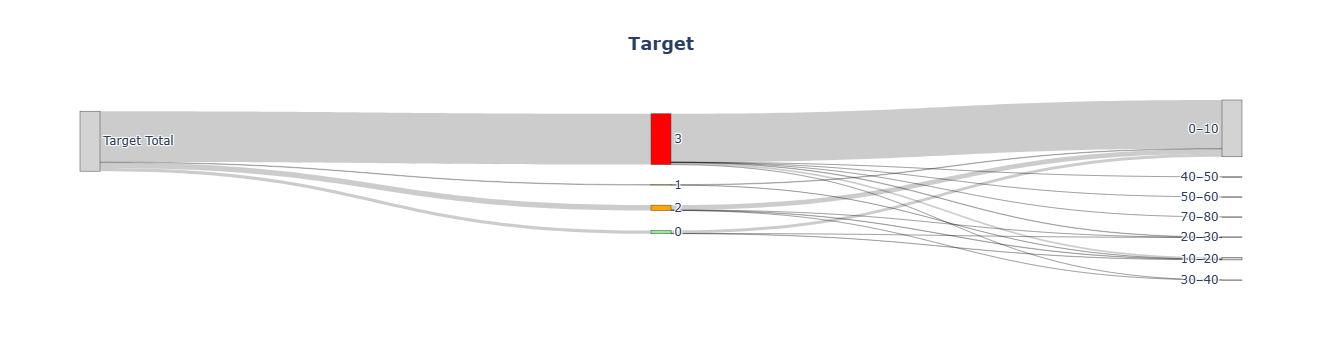

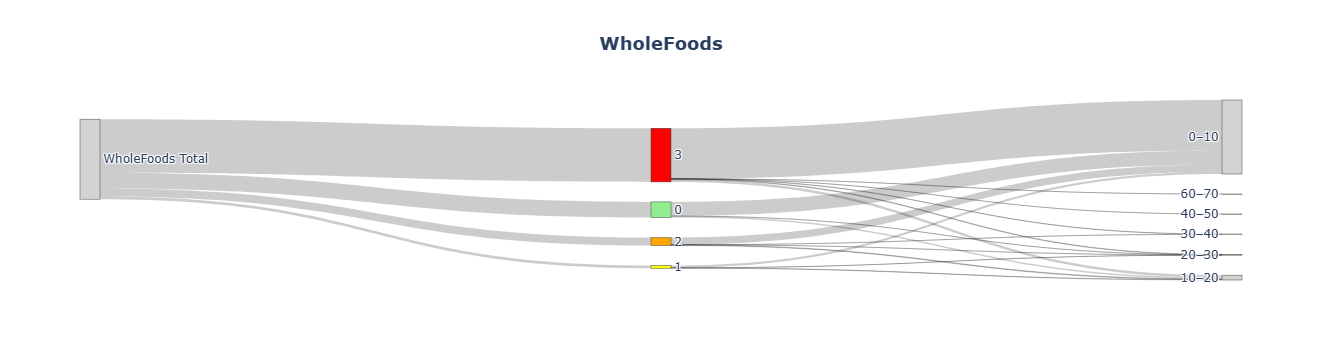

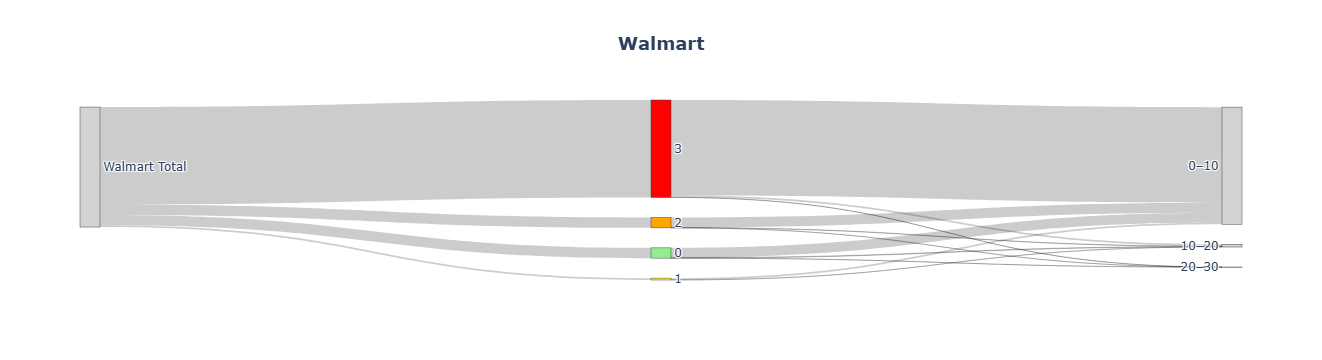

In [55]:

display(Markdown("<center><h1><strong>The Rise of Highly-Processed Foods: How Do Grocery Stores Map Food Processing Score to Price?</strong></h1></center>"))
display(Markdown("<center><h3>Cheap and highly-processed foods dominate shelves!</h3></center>"))


# Loop over each store
for store in df["store"].unique():
    df_store = df[df["store"] == store].copy()
    df_store["combined"] = f"{store} Total"

    # All node labels: combined → class → bin
    labels = pd.concat([df_store["combined"], df_store["FPro_class"], df_store["bin"]]).unique().tolist()
    label_idx = {label: i for i, label in enumerate(labels)}

    source = []
    target = []
    value = []

    # Step 1: combined → class
    flow1 = df_store.groupby(["combined", "FPro_class"]).size().reset_index(name="value")
    for _, row in flow1.iterrows():
        source.append(label_idx[row["combined"]])
        target.append(label_idx[row["FPro_class"]])
        value.append(row["value"])

    # Step 2: class → bin
    flow2 = df_store.groupby(["FPro_class", "bin"]).size().reset_index(name="value")
    for _, row in flow2.iterrows():
        source.append(label_idx[row["FPro_class"]])
        target.append(label_idx[row["bin"]])
        value.append(row["value"])

    # Color classes only (middle layer)
    class_labels = df_store["FPro_class"].unique().tolist()
    
    # Assign specific colors to each class (adjust as you like)
    class_colors = {
        "0": "#90EE90",  # light red
        "1": "#FFFF00",  # light blue
        "2": "#FFA500",  # light green
        "3": "#FF0000",  # light orange
    }
    
    # Build full node color list
    node_colors = []
    for label in labels:
        if label in class_colors:
            node_colors.append(class_colors[label])
        else:
            node_colors.append("lightgray")  # default color for other nodes
        
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=20,
            thickness=20,
            label=labels,
            color=node_colors  # ← use the color list here
        ),
        link=dict(
            source=source,
            target=target,
            value=value
        )
    )])

    fig.update_layout(
        title=dict(
            text=f"<b>{store}</b>",
            font=dict(size=18),
            x=0.5,  # center the title
            xanchor='center'
        ),
        font=dict(size=12)
    )
    
    fig.show()